In [7]:
#FM Modulation

%matplotlib ipympl
import numpy as np
import soundfile as sf
from scipy.io import wavfile
from scipy.signal import resample, hilbert
import matplotlib.pyplot as plt

# Parameters
CARRIER_FREQ = 100e3       # Carrier frequency (Hz)
FREQ_DEV = 5e3             # Frequency deviation
FS_OUT = 500e3             # FM signal sample rate
SNR_dB = 20                # Signal-to-Noise Ratio in dB

# 1. Load and normalize audio
audio, fs_audio = sf.read("Test_audio.wav")
#fs_audio, audio = wavfile.read("Test_audio.wav")
if audio.ndim > 1:
    audio = audio[:, 0]
audio /= np.max(np.abs(audio))

# 2. Resample audio to match FM sample rate
num_samples = int(len(audio) * FS_OUT / fs_audio)
audio_resampled = resample(audio, num_samples)

# 3. FM Modulation (complex baseband)
dt = 1 / FS_OUT
kf = 2 * np.pi * FREQ_DEV
integrated_audio = np.cumsum(audio_resampled) * dt
fm_signal = np.exp(1j * kf * integrated_audio)

# 4. Add AWGN
def add_awgn(signal, snr_db):
    signal_power = np.mean(np.abs(signal)**2)
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power / 2) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))
    return signal + noise

noisy_fm_signal = add_awgn(fm_signal, SNR_dB)

In [8]:
#Save both real and imag as stereo channels
stereo_signal = np.stack((np.real(noisy_fm_signal), np.imag(noisy_fm_signal)), axis=1)
sf.write("noisy_fm_signal_stereo.wav", stereo_signal.astype(np.float32), int(FS_OUT))

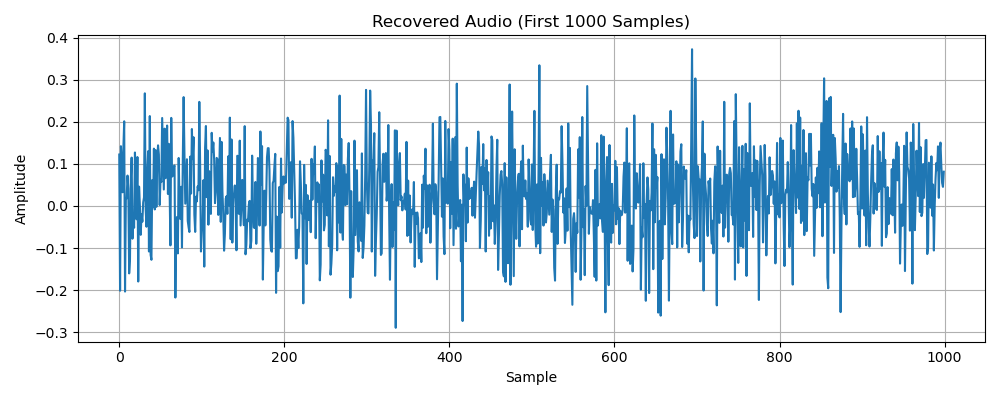

In [9]:
# 5. FM Demodulation (for verification)

demodulated = np.angle(noisy_fm_signal[1:] * np.conj(noisy_fm_signal[:-1])) / (2 * np.pi * FREQ_DEV * dt)
demodulated = np.clip(demodulated, -1.0, 1.0)  # Optional clipping

# 6. Resample back to original audio sample rate
recovered_audio = resample(demodulated, len(audio))

# 7. Save recovered audio
sf.write("recovered_audio.wav", recovered_audio, fs_audio)

# Optional: Plot
plt.figure(figsize=(10, 4))
plt.plot(recovered_audio[:1000])
plt.title("Recovered Audio (First 1000 Samples)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid()
plt.tight_layout()
plt.show()